SVD Сжатие изображений - полный анализ
Этот ноутбук выполняет сингулярное разложение (SVD) для сжатия черно-белого изображения.

## 1. Импорт библиотек

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline

## 2. Загрузка изображения

In [5]:
# Способ 1: путь к файлу в переменной
# filename = "путь/к/вашему/изображению.jpg"

# Способ 2: путь через консоль
filename = input("Введите путь к изображению: ").strip()

# Проверка существования файла
if not os.path.exists(filename):
    raise FileNotFoundError(f"Файл '{filename}' не найден.")

# Преобразуем в чёрно-белое для простоты
img = Image.open(filename).convert('L')
img_array = np.array(img, dtype=np.float64)

print(f"✓ Изображение загружено: {os.path.basename(filename)}")
print(f"✓ Размер: {img_array.shape}")
print(f"✓ Всего пикселей: {img_array.size}")

Введите путь к изображению:  ./photo_2025-12-19_08-16-35.jpg


✓ Изображение загружено: photo_2025-12-19_08-16-35.jpg
✓ Размер: (450, 1024)
✓ Всего пикселей: 460800


## 3. Выполнение SVD

In [6]:
U, S, Vt = np.linalg.svd(img_array, full_matrices=False)
print(f"SVD выполнено успешно")
print(f"Всего сингулярных значений: {len(S)}")

SVD выполнено успешно
Всего сингулярных значений: 450


## 4. Восстановление изображений с разным числом сингулярных чисел

In [7]:
k_values = [1, 5, 10, 30, 50, 100]
reconstructed_images = []
storage_info = []

# Функция для восстановления
def reconstruct_svd(k):
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

# Восстанавливаем для всех k
for k in k_values:
    reconstructed = reconstruct_svd(k)
    reconstructed_images.append(reconstructed)

    # Расчет размера хранения
    m, n = img_array.shape
    compressed_size = (m * k + k + n * k) * 8  # float64
    original_size = m * n * 8
    compression_ratio = original_size / compressed_size
    energy_retained = np.sum(S[:k]) / np.sum(S) * 100
    mse = np.mean((img_array - reconstructed) ** 2)

    storage_info.append({
        'k': k,
        'size_bytes': compressed_size,
        'compression_ratio': compression_ratio,
        'energy_retained': energy_retained,
        'mse': mse
    })

## 5. Визуализация результатов

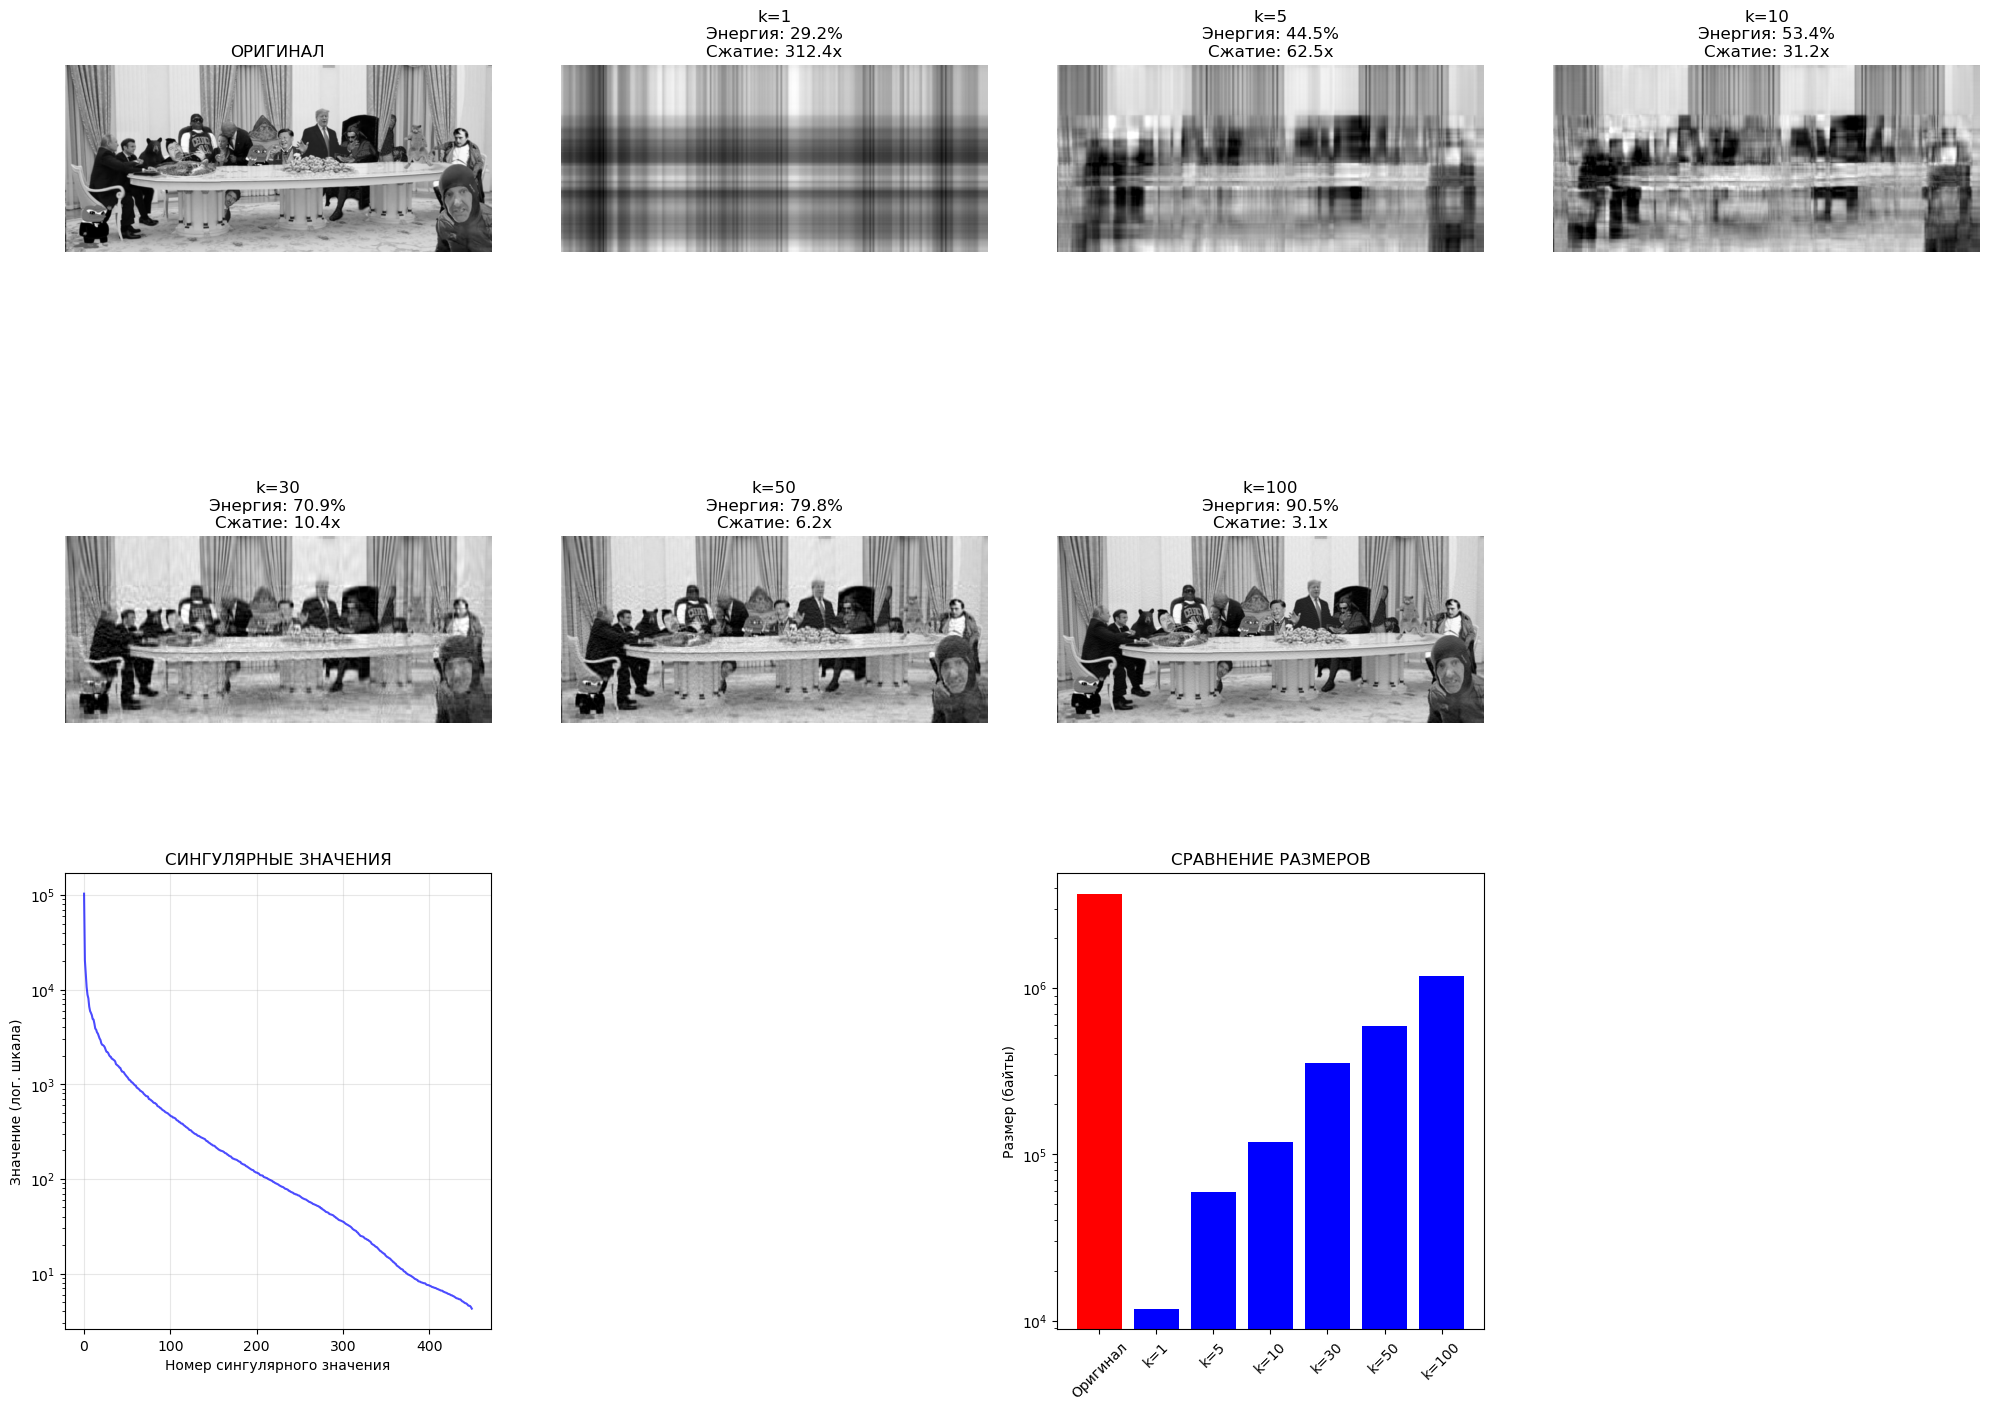

In [8]:
# Создаем большую фигуру для всех графиков
plt.figure(figsize=(20, 15))

# Сравнение восстановленных изображений
plt.subplot(3, 4, 1)
plt.imshow(img_array, cmap='gray')
plt.title('ОРИГИНАЛ')
plt.axis('off')

for i, (k, recon_img) in enumerate(zip(k_values, reconstructed_images)):
    plt.subplot(3, 4, i + 2)
    plt.imshow(np.clip(recon_img, 0, 255).astype(np.uint8), cmap='gray')
    info = storage_info[i]
    plt.title(f'k={k}\nЭнергия: {info["energy_retained"]:.1f}%\nСжатие: {info["compression_ratio"]:.1f}x')
    plt.axis('off')

# График сингулярных значений
plt.subplot(3, 4, 9)
plt.semilogy(S, 'b-', alpha=0.7)
plt.xlabel('Номер сингулярного значения')
plt.ylabel('Значение (лог. шкала)')
plt.title('СИНГУЛЯРНЫЕ ЗНАЧЕНИЯ')
plt.grid(True, alpha=0.3)

# Сравнение размеров хранения
plt.subplot(3, 4, 11)
sizes = [info['size_bytes'] for info in storage_info]
labels = [f'k={k}' for k in k_values]

plt.bar(['Оригинал'] + labels, [original_size] + sizes,
        color=['red'] + ['blue'] * len(k_values))
plt.ylabel('Размер (байты)')
plt.title('СРАВНЕНИЕ РАЗМЕРОВ')
plt.xticks(rotation=45)
plt.yscale('log')

plt.tight_layout()
plt.show()

## 6. Таблица сравнения

In [9]:
print(f"{'Кол-во k':<10} {'Размер (байт)':<15} {'Сжатие':<10} {'Энергия':<10} {'MSE':<10}")

# Оригинал
print(f"{'Оригинал':<10} {original_size:<15} {'1.0x':<10} {'100.0%':<10} {'0.0':<10}")

# Сжатые версии
for info in storage_info:
    print(f"{info['k']:<10} {info['size_bytes']:<15} {info['compression_ratio']:<10.1f} "
          f"{info['energy_retained']:<10.1f} {info['mse']:<10.1f}")

Кол-во k   Размер (байт)   Сжатие     Энергия    MSE       
Оригинал   3686400         1.0x       100.0%     0.0       
1          11800           312.4      29.2       2852.7    
5          59000           62.5       44.5       1088.5    
10         118000          31.2       53.4       640.9     
30         354000          10.4       70.9       194.2     
50         590000          6.2        79.8       83.5      
100        1180000         3.1        90.5       16.8      
